# How accurate is the OpenPrescribing Price Concession analysis, and can we improve it?

Price Concessions occur when pharmacies are unable to buy stock for the price listed in the Drug Tariff. These higher prices are usually due to stock availability issues.

Currently the PSNC and Department of Health agree on a "price concession" at points during the month where the items have been dispensed.  This means that people are not able to find out the increased cost before dispensing.

OpenPrescribing has a tool which allows an estimate of additional costs to be presented (and emailed) to users, based on a number of assumptions:

- As the prescribing data is not available for the period, we use the data which is nearest available, which is usually two months beforehand.
- We assume the national average percentage discount is 7.2%

As the impact of price concessions are increasing, we thought it was time to undertake an analysis to see if our forecasting methodology was accurate enough for our users.


In [1]:
import os
import pandas as pd
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
#from matplotlib.dates import  DateFormatter
%matplotlib inline
from ebmdatalab import bq
from ebmdatalab import charts
import lxml
#from ebmdatalab import maps
#import datetime as dtimport datetime
import datetime

We need to import data from BigQuery to undertake the analysis.

One of the issues with estimating the costs of price concessions is that the concession is at an individual pack size (or `VMPP`) level, whereas prescribing data is at presentation level, and therefore may have multiple pack sizes involved.  The SQL below includes a process to only select one pack size, and if there is a difference in the cost per unit, selects the one with the highest impact on spend.



### Import data from BigQuery

In [2]:
sql = """
WITH 
  price_concession AS (--subquery to remove duplicates due to different pack sizes
  SELECT
    ncso.date AS month, --month
    ncso.drug AS name,  -- drug name
    vmpp.bnf_code AS bnf_code, --BNF code from VMPP table
    ncso.price_pence AS pc_price_pence, --price concession cost per pack
    dt.price_pence AS dt_price_pence, --Drug Tariff cost per pack
    qtyval, --VMPP pack size
    (ncso.price_pence - dt.price_pence)/qtyval AS increased_ppu --difference between concession and usual Drug Tariff price
  FROM
    ebmdatalab.dmd.ncsoconcession AS ncso --concession table
  INNER JOIN
    dmd.vmpp_full AS vmpp --VMPP table
  ON
    ncso.vmpp = vmpp.id
  INNER JOIN
    dmd.tariffprice AS dt -- Drug Tariff table
  ON
    ncso.vmpp = dt.vmpp
    AND ncso.date = dt.date
  QUALIFY ROW_NUMBER() OVER (PARTITION BY ncso.date, vmpp.bnf_code ORDER BY (ncso.price_pence - dt.price_pence)/qtyval DESC) = 1 -- for each bnf_code and pack size, calculates PPU difference and ranks in order. Takes the top value, therefore only keeping the highest impact pack size, and thereby removes duplicates for pack size
  ORDER BY
    ncso.date,
    vmpp.bnf_code),
  rx_data AS (--subquery to create prescribing calculations)
  SELECT
    rx.month AS month,
    bnf_name,
    bnf_code AS bnf_code,
    SUM(quantity) AS quantity,
    SUM(net_cost) AS nic,
    SUM(actual_cost) AS actual_cost
  FROM
    ebmdatalab.hscic.normalised_prescribing AS rx
  GROUP BY
    rx.month,
    bnf_name,
    bnf_code)

#main query

SELECT
  rx.month,
  rx.bnf_name,
  rx.bnf_code,
  rx.quantity AS quantity,
  rx_old.quantity AS quantity_2_months_previously ,
  rx.nic,
  rx.actual_cost,
  dt_price_pence/(100*qtyval) AS normal_nic_per_unit, --calculates "normal" drug tariff price per unit
  pc_price_pence/(100*qtyval) AS predicted_nic_per_unit -- calculates price concession predicted cost per unit
FROM
  rx_data AS rx
INNER JOIN
  rx_data AS rx_old -- data from two months previously
ON
  rx.bnf_code = rx_old.bnf_code
  AND DATE(rx.month) = DATE_ADD(DATE(rx_old.month), INTERVAL 2 month) -- join to create data from two months ago
INNER JOIN
  price_concession AS ncso
ON
  DATE(rx.month) = ncso.month
  AND rx.bnf_code = ncso.bnf_code
WHERE rx.month >='2017-02-01'
  AND rx.month <'2023-04-01' 
ORDER BY
  rx.month 
"""

exportfile = os.path.join("..","data","ncso_df.csv") #defines name for cache file
ncso_df = bq.cached_read(sql, csv_path=exportfile, use_cache=True) #uses BQ if changed, otherwise csv cache file
ncso_df['month'] = ncso_df['month'].astype('datetime64[ns]') #ensure dates are in datetimeformat
ncso_df['normal_nic_per_unit'] = ncso_df['normal_nic_per_unit'].astype(float) #ensure in float format
ncso_df['predicted_nic_per_unit'] = ncso_df['predicted_nic_per_unit'].astype(float) #ensure in float format

Downloading: 100%|██████████| 5116/5116 [00:00<00:00, 7082.27rows/s]


Using the data imported, we can calculate the estimated impact of price concessions, using the same methodology that OpenPrescribing.net uses for initial predictions:
- Using a fixed 7.2% [Average National Discount Percentage (NADP)](https://digital.nhs.uk/data-and-information/areas-of-interest/prescribing/practice-level-prescribing-in-england-a-summary/practice-level-prescribing-glossary-of-terms#actual-cost)
- Using the latest data available at the time of estimate (usually two months behind)

We calculate the costs by multiplying the unit quantity dispensed two months previously by the predicted cost per unit geenerated in the SQL above * 0.928.  This gives us the predicted actual cost, which we then compare to the actual amount spend in that month, and calculate the difference.

In [3]:
#calculate predicted costs for each drug
ncso_df['predicted_actual_cost'] = ncso_df['quantity_2_months_previously'] * ncso_df['predicted_nic_per_unit'] * 0.928 #calculate predicted actual cost - multiply by 0.928 to get actual cost, using 2 months earlier quantity data as a prediction
ncso_df['prediction_difference'] = ncso_df['actual_cost'] - ncso_df['predicted_actual_cost'] #calculate difference in costs

In [4]:
#create total monthly data
ncso_sum_df=ncso_df.groupby(['month',])[['actual_cost','predicted_actual_cost', 'prediction_difference']].sum()  #group data to show total per month
ncso_sum_df['perc_difference'] = ncso_sum_df['prediction_difference'] / ncso_sum_df['actual_cost'] #calculate percentage difference
ncso_sum_df.sort_values(by=['month']) #sort values by month for chart
ncso_sum_df.reset_index(inplace=True)

Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend')

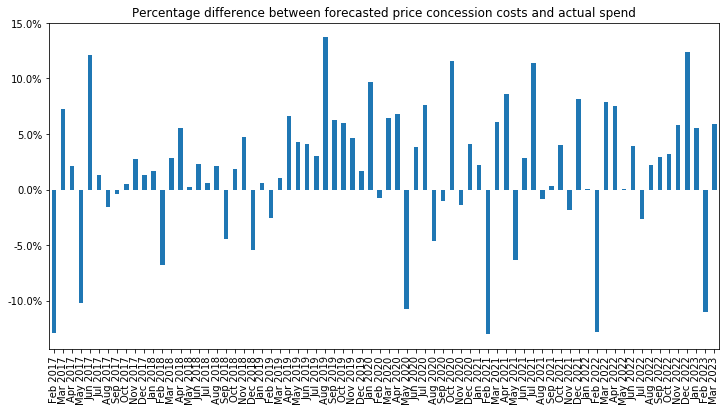

In [5]:
#create chart
ax = ncso_sum_df.plot.bar(figsize = (12,6), y= ['perc_difference'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend')

As we can see from the chart above, on a monthly basis the price concession data is usually accurate to within 5%.  The tool usually *overestimates* (i.e. a negative percentage) in February of each year, due to the difference in working or dispensing days between the actual month and the month used for prediction (December).  

### Impact within Financial Year

As the tool is mainly used to estimate the impact on finances within the NHS due to price concessions, it is also useful to see how accurate the tool is over the whole of a financial year.  Aggregating the data over a financial year is also a useful way of describe the average accuracy, which will always be flucuating on a monthly basis.

In [6]:
#create financial year grouping
ncso_fy_df = ncso_sum_df.groupby([pd.Grouper(key='month', freq="A-MAR")])[["actual_cost","predicted_actual_cost","prediction_difference"]].sum() #groups by financial year
ncso_fy_df['perc_difference'] = ncso_fy_df['prediction_difference'] / ncso_fy_df['actual_cost'] #recalculate percentage difference 
ncso_fy_df.reset_index(inplace=True)
#ncso_fy_df = ncso_fy_df.loc[ncso_fy_df["month"].between("2017-04-01", "2022-03-31")]
ncso_fy_df = ncso_fy_df.reset_index(drop=True)

In [7]:
ncso_fy_df.style

,month,actual_cost,predicted_actual_cost,prediction_difference,perc_difference
0,2017-03-31 00:00:00,16119658.567700,16451480.610140,-331822.042440,-0.020585
1,2018-03-31 00:00:00,433523479.687450,429048911.329842,4474568.357608,0.010321
2,2019-03-31 00:00:00,284692780.948200,284196072.843485,496708.104715,0.001745
3,2020-03-31 00:00:00,209156870.665860,197636304.120116,11520566.545744,0.055081
4,2021-03-31 00:00:00,248096345.115410,245757057.577647,2339287.537763,0.009429
5,2022-03-31 00:00:00,154178722.271120,151621054.057232,2557668.213888,0.016589
6,2023-03-31 00:00:00,629859332.666890,607577689.895597,22281642.771293,0.035376


Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend (financial year)')

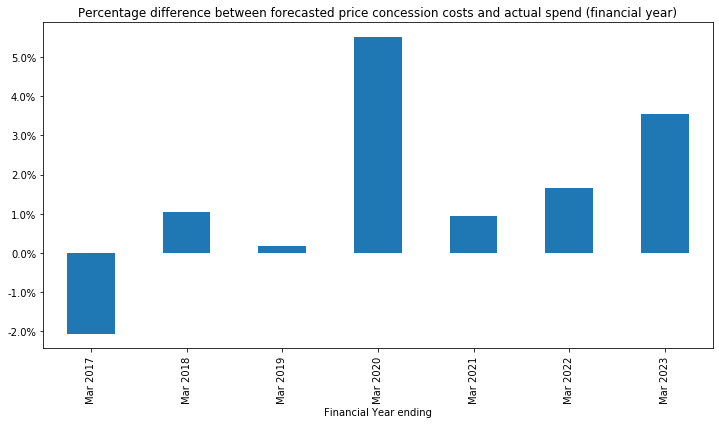

In [8]:
#create financial year group 
ax = ncso_fy_df.plot.bar(figsize = (12,6),  y= ['perc_difference'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_fy_df['month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_xlabel("Financial Year ending")
ax.set_title('Percentage difference between forecasted price concession costs and actual spend (financial year)')

As can be seen from the above, in four out of the five previous financial years the prediction tool correctly estimated within 2%.  The outlying year was 2019-2020, where the underestimation was likely to be due to the significant increase in items in March 2020 due to the onset of the coronavirus pandemic.

### Can we improve accuracy?

Although it would appear that the price concession tool is accurate to usually within 2%, as the predictions are less accurate on a monthly basis, are we able to improve this?

#### Use monthly National Average Discount Percentage

When the price concessions tool was built a few years ago, we decided to use the NADP that was available at the time (7.2%).  Since then it has fluctuated, and the monthly value (back to 2017) is published on the [NHS BSA website]('https://www.nhsbsa.nhs.uk/prescription-data/understanding-our-data/financial-forecasting').  We can therefore import the data and adjust the prediction calculations accordingly.  We do this in the data below by dividing 7.2% by the actual NADP value, creating a weighting value to adjust the predicted actual cost calculated above.

In [9]:
#import NADP data (to Feb 2023)
#importfile = os.path.join("..","data","nadp_fixed.csv") #define the name of the NADP import file
#nadp_df = pd.read_csv(importfile) #import NADP
#nadp_df['month'] = nadp_df['month'].astype('datetime64[ns]') #ensure correct date format
#nadp_df['nadp_weighting'] = (1-(nadp_df['nadp']/100))/0.928 #create weighting of "true" weighting for month vs assumed 7.2%
#ncso_fy_df.reset_index(inplace=True)


url = 'https://www.nhsbsa.nhs.uk/prescription-data/understanding-our-data/financial-forecasting' #url for NADP
dfs = pd.read_html(url,match='National Average Discount Percentage') #scrape nadp data from table
nadp = []
for i in range(len(dfs)):
    nadp.append(dfs[i])
nadp_df = pd.concat(nadp)
nadp_df.rename(columns={"Used for Reports in": "month", "National Average Discount Percentage": "nadp"}, inplace=True) #rename columns to more manageable names
nadp_df['month'] = nadp_df['month'].str[:3] + " " + nadp_df['month'].str[-2:] # there was inconsistencies in date naming, so create standardised mmm yy

def date_convert(date_to_convert):
    return datetime.datetime.strptime(date_to_convert, '%b %y').strftime('%Y-%m-%d') # define datetime function
    
nadp_df['month'] = nadp_df['month'].apply(date_convert).astype('datetime64[D]') #convert date string to datetime
nadp_df['nadp_weighting'] = (1-(nadp_df['nadp']/100))/0.928 #create weighting of "true" weighting for month vs assumed 7.2%








In [10]:
nadp_df.head()

,month,nadp,nadp_weighting
0,2023-08-01,6.34,1.009267
1,2023-07-01,6.32,1.009483
2,2023-06-01,5.91,1.013901
3,2023-05-01,5.83,1.014763
4,2023-04-01,5.87,1.014332


In [11]:
ncso_sum_df =  ncso_sum_df.merge(nadp_df[["month", "nadp_weighting"]]) #add weighting to grouped price concession data

In [12]:
ncso_sum_df.head(200)

,month,actual_cost,predicted_actual_cost,prediction_difference,perc_difference,nadp_weighting
0,2017-02-01,7.423218e+06,8.383616e+06,-9.603985e+05,-0.129378,0.998599
1,2017-03-01,8.696441e+06,8.067864e+06,6.285765e+05,0.072280,0.999138
2,2017-04-01,6.301537e+06,6.166398e+06,1.351393e+05,0.021445,0.997629
3,2017-05-01,1.235804e+07,1.361402e+07,-1.255981e+06,-0.101633,0.998922
4,2017-06-01,3.250022e+07,2.856964e+07,3.930588e+06,0.120940,0.998060
...,...,...,...,...,...,...
69,2022-11-01,6.483300e+07,6.109024e+07,3.742759e+06,0.057729,1.007543
70,2022-12-01,8.985689e+07,7.875115e+07,1.110574e+07,0.123594,1.007435
71,2023-01-01,6.742231e+07,6.370302e+07,3.719294e+06,0.055164,1.009591
72,2023-02-01,6.060747e+07,6.728187e+07,-6.674405e+06,-0.110125,1.010237


#### Weight for difference in days between prediction and actual months

As shown above, there are often larger differences between the predicted and actual cost in months that have the most different days, with February being the most obvious.  We can try and weight to change this, by looking at *work days* (Monday-Friday), *dispensing days* (Monday-Saturday), both excluding bank holidays, and work days *including* bank holidays (as patients will tend to pick up prescriptions anyway around Christmas and Easter).  We calculate the number of working and dispensing days below, and apply a weighting to adjust the predicted actual cost.

In [13]:
#import bank holiday data from gov.uk and pass to busdays function `holidays=[]`
url = 'https://www.gov.uk/bank-holidays.json'
bh = pd.read_json(url, orient='index')
bankhols = pd.json_normalize(bh.iloc[0]["events"]) #flattening json in pandas df
#calculate the number of working days (Mon-Fri) and dispensing days (Mon-Sat), excluding bank holidays
import calendar
dates = ncso_df[["month"]].drop_duplicates() # find data from price concession data
dates["month"] = pd.to_datetime(dates["month"])
dates["year"] = dates["month"].dt.year
dates["mon"] = dates["month"].dt.month
d = []
for row in dates.itertuples():
    y = row.year
    m = row.mon
    day = calendar.monthrange(y,m)[1]
    d.append(str(y)+"-"+str(m)+"-"+str(day))
d = pd.Series(d, name="enddates")
d = pd.to_datetime(d, format="%Y/%m/%d")
begindates = pd.Series(dates["month"]).values.astype('datetime64[D]')
enddates = pd.Series(d).values.astype('datetime64[D]') + 1 #busday_count function doesn't include the end day, so you have to add one day to the series.
#######
# find business days in month
dates["workdays"] = np.busday_count(begindates, enddates, weekmask = 'Mon Tue Wed Thu Fri', holidays=bankhols["date"].values.astype('datetime64[D]')) #Mon-Fri, excluding bank holidays
dates["nobhworkdays"] =np.busday_count(begindates, enddates, weekmask = 'Mon Tue Wed Thu Fri') #Mon-Fri, including bank holidays
dates["dispdays"] = np.busday_count(begindates, enddates, weekmask = 'Mon Tue Wed Thu Fri Sat', holidays=bankhols["date"].values.astype('datetime64[D]'))#Mon-Sat, excluding bank holidays
#dates = dates.set_index(pd.DatetimeIndex(dates['month']))
dates['workdays_predict_weighting'] = dates['workdays']/dates['workdays'].shift(2) #calculate weighting to apply for workdays, comparing actual month with data used from two months previously
dates['nobhworkdays_predict_weighting'] = dates['nobhworkdays']/dates['nobhworkdays'].shift(2) #calculate weighting to apply for workdays, comparing actual month with data used from two months previously
dates['dispdays_predict_weighting'] = dates['dispdays']/dates['dispdays'].shift(2) #calculate weighting to apply for dispensing days, comparing actual month with data used from two months previously
#dates = dates.set_index('month')
dates = dates.sort_values(by=['month']) #sort values by month for chart

In [14]:
dates.head(200)

,month,year,mon,workdays,nobhworkdays,dispdays,workdays_predict_weighting,nobhworkdays_predict_weighting,dispdays_predict_weighting
0,2017-02-01,2017,2,20,20,24,NaN,NaN,NaN
28,2017-03-01,2017,3,23,23,27,NaN,NaN,NaN
57,2017-04-01,2017,4,20,20,25,1.000000,1.000000,1.041667
84,2017-05-01,2017,5,23,23,27,1.000000,1.000000,1.000000
113,2017-06-01,2017,6,22,22,26,1.100000,1.100000,1.040000
...,...,...,...,...,...,...,...,...,...
4262,2022-11-01,2022,11,22,22,26,1.047619,1.000000,1.040000
4414,2022-12-01,2022,12,20,22,25,0.952381,1.047619,0.961538
4603,2023-01-01,2023,1,21,22,25,0.954545,1.000000,0.961538
4774,2023-02-01,2023,2,20,20,24,1.000000,0.909091,0.960000


We can also weight the effect that number of days in a month has by looking at the number of items prescribed in each month in six major chapters of the BNF, and see how it changes throughout the year, using the methodology below.  We are using five years worth of data, ending in February 2020, as the pandemic affected the number of items prescribed per month from March 2020 onwards.

In [15]:
#calculate average proportion of prescriptions per monnth in major rx chapters
sql = """
SELECT
  EXTRACT (month
  FROM
    rx.month) AS mon, #create month of the year only
  SUM(rx.items /total_rx.total_items)/(1/12) AS proportion #calculate the relative number of prescriptions dispensed in a month, compared with fixed one-twelth
FROM
  hscic.normalised_prescribing AS rx,
  (
  SELECT
    SUM(items) AS total_items
  FROM
    hscic.normalised_prescribing
  WHERE
    month BETWEEN'2016-03-01'
    AND '2020-02-01'
    AND SUBSTR(bnf_code,0,2) IN ('01',
      '02',
      '03',
      '04',
      '06',
      '10'))AS total_rx
WHERE
  month BETWEEN'2016-03-01'
  AND '2020-02-01'
  AND SUBSTR(bnf_code,0,2) IN ('01',
    '02',
    '03',
    '04', 
    '06',
    '10')
GROUP BY
  mon
"""

exportfile = os.path.join("..","data","annual_profile_df.csv")
annual_profile_df = bq.cached_read(sql, csv_path=exportfile, use_cache=True)

In [16]:
#add the profile data to the existing date dataframe
dates = pd.merge(dates, annual_profile_df, on=["mon"]) #merge the profile data into the dates df
dates = dates.set_index('month')
dates = dates.sort_values(by=['month']) #sort values by month for chart in order to allow calculation of weighting from 2 months earlier
dates['profile_weighting'] = dates['proportion']/dates['proportion'].shift(2) # calculate difference in profile proportions
dates.reset_index(inplace=True)

### Assessing different weightings on accuracy of price concessions

First we need to add the date weighting data to the price concession data

In [17]:
ncso_sum_df =  ncso_sum_df.merge(dates[["month", "workdays_predict_weighting","nobhworkdays_predict_weighting","dispdays_predict_weighting","profile_weighting"]]) #add weighting to grouped price concession data
ncso_sum_df.head(200) #show updated dataframe

,month,actual_cost,predicted_actual_cost,prediction_difference,perc_difference,nadp_weighting,workdays_predict_weighting,nobhworkdays_predict_weighting,dispdays_predict_weighting,profile_weighting
0,2017-02-01,7.423218e+06,8.383616e+06,-9.603985e+05,-0.129378,0.998599,NaN,NaN,NaN,NaN
1,2017-03-01,8.696441e+06,8.067864e+06,6.285765e+05,0.072280,0.999138,NaN,NaN,NaN,NaN
2,2017-04-01,6.301537e+06,6.166398e+06,1.351393e+05,0.021445,0.997629,1.000000,1.000000,1.041667,1.047647
3,2017-05-01,1.235804e+07,1.361402e+07,-1.255981e+06,-0.101633,0.998922,1.000000,1.000000,1.000000,1.001955
4,2017-06-01,3.250022e+07,2.856964e+07,3.930588e+06,0.120940,0.998060,1.100000,1.100000,1.040000,1.027525
...,...,...,...,...,...,...,...,...,...,...
69,2022-11-01,6.483300e+07,6.109024e+07,3.742759e+06,0.057729,1.007543,1.047619,1.000000,1.040000,1.027765
70,2022-12-01,8.985689e+07,7.875115e+07,1.110574e+07,0.123594,1.007435,0.952381,1.047619,0.961538,1.002596
71,2023-01-01,6.742231e+07,6.370302e+07,3.719294e+06,0.055164,1.009591,0.954545,1.000000,0.961538,1.010609
72,2023-02-01,6.060747e+07,6.728187e+07,-6.674405e+06,-0.110125,1.010237,1.000000,0.909091,0.960000,0.911135


We now need to see whether the updated NADP improves the prediction further, by calculating the impact of the NADP weighting:

In [18]:
ncso_sum_df["nadp_predicted_actual_cost"] = ncso_sum_df["predicted_actual_cost"] * ncso_sum_df["nadp_weighting"] # calculate the predicted actual cost using NADP weighting
ncso_sum_df["nadp_prediction_difference"] = ncso_sum_df["actual_cost"] - ncso_sum_df["nadp_predicted_actual_cost"] # calculate #difference using NADP
ncso_sum_df['nadp_perc_difference'] = ncso_sum_df['nadp_prediction_difference'] / ncso_sum_df['actual_cost'] #calculate percentage difference using NADP
ncso_sum_df.reset_index(drop=True)

,month,actual_cost,predicted_actual_cost,prediction_difference,perc_difference,nadp_weighting,workdays_predict_weighting,nobhworkdays_predict_weighting,dispdays_predict_weighting,profile_weighting,nadp_predicted_actual_cost,nadp_prediction_difference,nadp_perc_difference
0,2017-02-01,7.423218e+06,8.383616e+06,-9.603985e+05,-0.129378,0.998599,NaN,NaN,NaN,NaN,8.371872e+06,-9.486542e+05,-0.127796
1,2017-03-01,8.696441e+06,8.067864e+06,6.285765e+05,0.072280,0.999138,NaN,NaN,NaN,NaN,8.060909e+06,6.355315e+05,0.073079
2,2017-04-01,6.301537e+06,6.166398e+06,1.351393e+05,0.021445,0.997629,1.000000,1.000000,1.041667,1.047647,6.151779e+06,1.497580e+05,0.023765
3,2017-05-01,1.235804e+07,1.361402e+07,-1.255981e+06,-0.101633,0.998922,1.000000,1.000000,1.000000,1.001955,1.359935e+07,-1.241311e+06,-0.100446
4,2017-06-01,3.250022e+07,2.856964e+07,3.930588e+06,0.120940,0.998060,1.100000,1.100000,1.040000,1.027525,2.851422e+07,3.986003e+06,0.122645
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2022-11-01,6.483300e+07,6.109024e+07,3.742759e+06,0.057729,1.007543,1.047619,1.000000,1.040000,1.027765,6.155105e+07,3.281949e+06,0.050622
70,2022-12-01,8.985689e+07,7.875115e+07,1.110574e+07,0.123594,1.007435,0.952381,1.047619,0.961538,1.002596,7.933669e+07,1.052019e+07,0.117077
71,2023-01-01,6.742231e+07,6.370302e+07,3.719294e+06,0.055164,1.009591,0.954545,1.000000,0.961538,1.010609,6.431396e+07,3.108349e+06,0.046103
72,2023-02-01,6.060747e+07,6.728187e+07,-6.674405e+06,-0.110125,1.010237,1.000000,0.909091,0.960000,0.911135,6.797064e+07,-7.363174e+06,-0.121490


Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend, using NAPD')

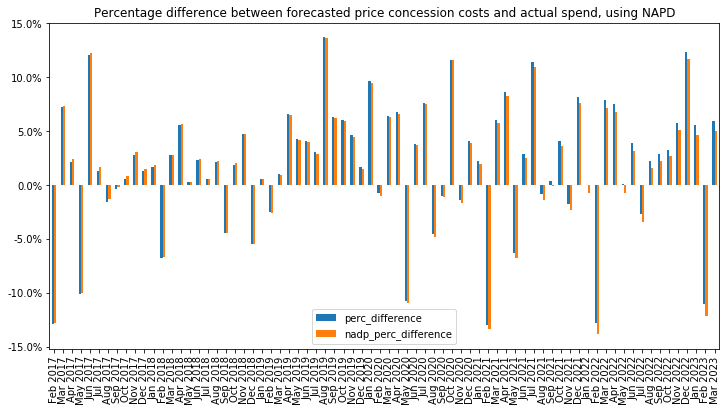

In [19]:
#create chart
ax = ncso_sum_df.plot.bar(figsize = (12,6), y= ['perc_difference', 'nadp_perc_difference'], legend=True)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend, using NAPD')

In [20]:
#create financial year grouping
ncso_fy_df = ncso_sum_df.groupby([pd.Grouper(key='month', freq="A-MAR")])[["actual_cost","predicted_actual_cost","prediction_difference", "nadp_predicted_actual_cost","nadp_prediction_difference"]].sum() #groups by financial year
ncso_fy_df['perc_difference'] = ncso_fy_df['prediction_difference'] / ncso_fy_df['actual_cost'] #recalculate percentage difference
ncso_fy_df['nadp_perc_difference'] = ncso_fy_df['nadp_prediction_difference'] / ncso_fy_df['actual_cost'] #recalculate percentage difference with NAPD
ncso_fy_df.reset_index(inplace=True)
#ncso_fy_df = ncso_fy_df.loc[ncso_fy_df["month"].between("2017-04-01", "2022-03-31")]
ncso_fy_df = ncso_fy_df.reset_index(drop=True)

Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend (financial year) NADP')

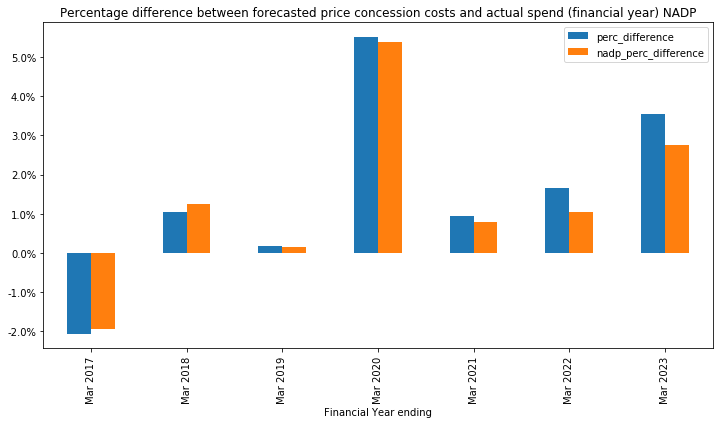

In [21]:
#create financial year group 
ax = ncso_fy_df.plot.bar(figsize = (12,6),  y= ['perc_difference','nadp_perc_difference'], legend=True)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_fy_df['month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_xlabel("Financial Year ending")
ax.set_title('Percentage difference between forecasted price concession costs and actual spend (financial year) NADP')

We can see from the graph above that there is a *slight* improvement for most financial years by adding in an adjustment for correct NADP, rather than the fixed value we currently use.  The improvement appears to increase with time.

We can now calculate how the different weightings for adjusting for days in the month affect the accuracy of the prediction, using the monthly NADP:

In [22]:
ncso_sum_df["profile_predicted_actual_cost"] = ncso_sum_df["predicted_actual_cost"] * ncso_sum_df["profile_weighting"]
ncso_sum_df["profile_prediction_difference"] = ncso_sum_df["profile_predicted_actual_cost"] - ncso_sum_df["actual_cost"]
ncso_sum_df["perc_profile_prediction_difference"] = ncso_sum_df["profile_prediction_difference"] / ncso_sum_df["actual_cost"]

ncso_sum_df["profile_nadp_predicted_actual_cost"] = ncso_sum_df["predicted_actual_cost"] * ncso_sum_df["nadp_weighting"] * ncso_sum_df["profile_weighting"]
ncso_sum_df["profile_nadp_prediction_difference"] = ncso_sum_df["profile_nadp_predicted_actual_cost"] - ncso_sum_df["actual_cost"]
ncso_sum_df["perc_profile_nadp_prediction_difference"] = ncso_sum_df["profile_nadp_prediction_difference"] / ncso_sum_df["actual_cost"]

ncso_sum_df["dispdays_nadp_predicted_actual_cost"] = ncso_sum_df["predicted_actual_cost"] * ncso_sum_df["nadp_weighting"] * ncso_sum_df["dispdays_predict_weighting"]
ncso_sum_df["dispdays_nadp_prediction_difference"] = ncso_sum_df["dispdays_nadp_predicted_actual_cost"] - ncso_sum_df["actual_cost"]
ncso_sum_df["perc_dispdays_nadp_prediction_difference"] = ncso_sum_df["dispdays_nadp_prediction_difference"] / ncso_sum_df["actual_cost"]

ncso_sum_df["workdays_nadp_predicted_actual_cost"] = ncso_sum_df["predicted_actual_cost"] * ncso_sum_df["nadp_weighting"] * ncso_sum_df["workdays_predict_weighting"]
ncso_sum_df["workdays_nadp_prediction_difference"] = ncso_sum_df["workdays_nadp_predicted_actual_cost"] - ncso_sum_df["actual_cost"]
ncso_sum_df["perc_workdays_nadp_prediction_difference"] = ncso_sum_df["workdays_nadp_prediction_difference"] / ncso_sum_df["actual_cost"]

ncso_sum_df["nobhworkdays_nadp_predicted_actual_cost"] = ncso_sum_df["predicted_actual_cost"] * ncso_sum_df["nadp_weighting"] * ncso_sum_df["nobhworkdays_predict_weighting"]
ncso_sum_df["nobhworkdays_nadp_prediction_difference"] = ncso_sum_df["nobhworkdays_nadp_predicted_actual_cost"] - ncso_sum_df["actual_cost"]
ncso_sum_df["perc_nobhworkdays_nadp_prediction_difference"] = ncso_sum_df["nobhworkdays_nadp_prediction_difference"] / ncso_sum_df["actual_cost"]

In [23]:
#create financial year grouping
ncso_fy_df = ncso_sum_df.groupby([pd.Grouper(key='month', freq="A-MAR")])[["actual_cost","predicted_actual_cost","prediction_difference","nadp_predicted_actual_cost","profile_predicted_actual_cost","profile_prediction_difference","profile_nadp_predicted_actual_cost","profile_nadp_prediction_difference","dispdays_nadp_predicted_actual_cost","dispdays_nadp_prediction_difference","workdays_nadp_predicted_actual_cost","workdays_nadp_prediction_difference","nobhworkdays_nadp_predicted_actual_cost","nobhworkdays_nadp_prediction_difference"]].sum() #groups by financial year
ncso_fy_df['perc_difference'] = ncso_fy_df['prediction_difference'] / ncso_fy_df['actual_cost'] #recalculate percentage difference
ncso_fy_df['perc_difference_profile'] = ncso_fy_df['profile_prediction_difference'] / ncso_fy_df['actual_cost'] #recalculate percentage difference 
ncso_fy_df['perc_difference_nadp_profile'] = ncso_fy_df['profile_nadp_prediction_difference'] / ncso_fy_df['actual_cost'] #recalculate percentage difference
ncso_fy_df['perc_difference_nadp_dispdays'] = ncso_fy_df['dispdays_nadp_prediction_difference'] / ncso_fy_df['actual_cost'] #recalculate percentage difference 
ncso_fy_df['perc_difference_nadp_workdays'] = ncso_fy_df['workdays_nadp_prediction_difference'] / ncso_fy_df['actual_cost'] #recalculate percentage difference 
ncso_fy_df['perc_difference_nadp_nobhworkdays'] = ncso_fy_df['nobhworkdays_nadp_prediction_difference'] / ncso_fy_df['actual_cost'] #recalculate percentage difference 
ncso_fy_df.reset_index(inplace=True)
#ncso_fy_df = ncso_fy_df.loc[ncso_fy_df["month"].between("2017-04-01", "2022-03-31")]
ncso_fy_df = ncso_fy_df.reset_index(drop=True)

Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend (financial year)\n using different methodologies')

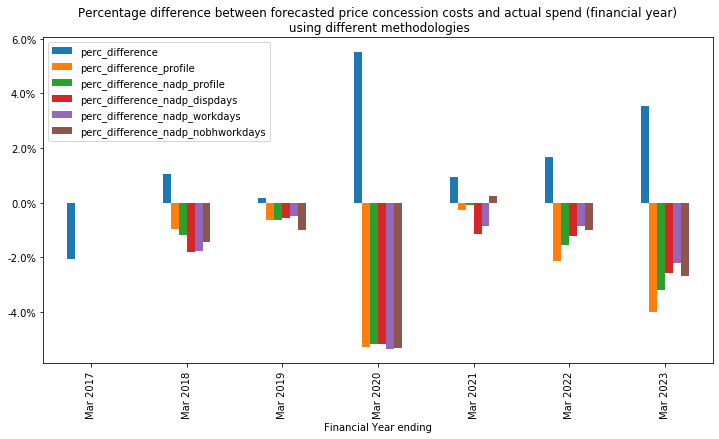

In [24]:
#create financial year group 
ax = ncso_fy_df.plot.bar(figsize = (12,6), y= ['perc_difference','perc_difference_profile','perc_difference_nadp_profile', 'perc_difference_nadp_dispdays','perc_difference_nadp_workdays','perc_difference_nadp_nobhworkdays'], legend=True)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_fy_df['month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_xlabel("Financial Year ending")
ax.set_title('Percentage difference between forecasted price concession costs and actual spend (financial year)\n using different methodologies')

As you can see above, adjusting for number of days in a month has a minimal impact on the accuracy of the prediction tool.  It appears that using both the NADP profile and the number of working days in the month has the closest prediction.  Financial Year 2019-2020 should be excluded due to the impact of the pandemic in March 2020.

## Conclusions

The OpenPrescribing.net price concessions prediction tool appears to be highly accurate when using the current methodology.  For the previous 5 years this is usually within 2% in a financial year, with 2019-2020 being an outlier for well-documented reasons.
2% is certainly accurate enough for planning and awareness in NHS organisations, particularly when the tool is able to identify areas of increased spend as soon as the price concessions have been released on a daily basis.

There is the opportunitity to _slightly_ improve the methodology, in two ways:
- We should consider using the current monthyl NADP profile, as opposed to the 7.2% fixed value we currently use.  This could be scraped on a monthly basis from the NHSBSA website.
- We could consider number of workdays (excluding bank holidays) to further improve the accuracy.  This may require greater redesign of the tool.

It's important to note that, given the over 98% accuracy within a financial year, that both of these changes are marginal, and may not be considered a priroity at this time.